In [5]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import seaborn as sn
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import auc
from sklearn.metrics import roc_curve                # Calculate the ROC curve
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score


In [9]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point


def ROC(label, y_prob):
    fpr, tpr, thresholds = roc_curve(label, y_prob)
    roc_auc = auc(fpr, tpr)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    return fpr, tpr, roc_auc, optimal_th, optimal_point
    

In [2]:
# Data Loading
f = r'C:\Users\User\VSCode\CDSS(20220401).xlsx'

CDSS = pd.read_excel(f, dtype={'病歷號碼':'str'})
m = CDSS[CDSS.openTime==CDSS.minTime]

In [55]:
# CDSS.openTime = pd.to_datetime(CDSS.openTime)
# CDSS.minTime = pd.to_datetime(CDSS.minTime)
# M = CDSS[CDSS.openTime==CDSS.minTime]
# M.count()

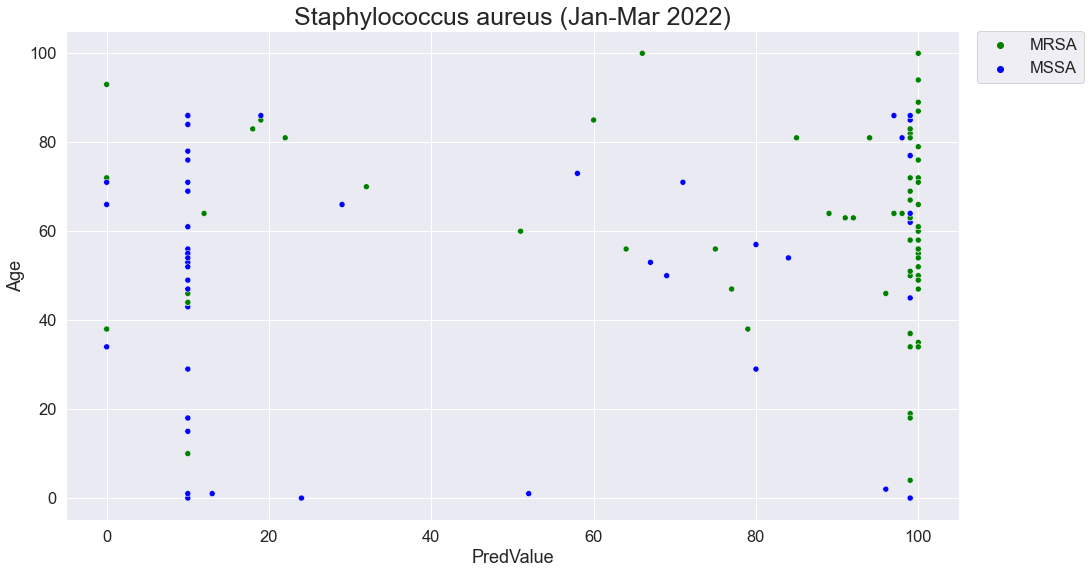

Strain: Staphylococcus aureus (Jan-Mar 2022)
Amount: 149
Patient: 95

PredLevel  Resist
0~20%      MRSA      14
           MSSA      35
21~40%     MRSA       2
           MSSA       2
41~60%     MRSA       2
           MSSA       2
61~80%     MRSA       5
           MSSA       5
81~100%    MRSA      68
           MSSA      14
Name: Resist, dtype: int64


,count,mean,std,min,25%,50%,75%,max
PredLevel,,,,,,,,
0~20%,49.0,9.000000,4.541476,0.0,10.00,10.0,10.00,19.0
21~40%,4.0,26.750000,4.573474,22.0,23.50,26.5,29.75,32.0
41~60%,4.0,55.250000,4.425306,51.0,51.75,55.0,58.50,60.0
61~80%,10.0,72.800000,6.142746,64.0,67.50,73.0,78.50,80.0
81~100%,82.0,98.426829,2.981550,84.0,99.00,99.0,100.00,100.0


In [50]:
# Staphylococcus aureus

SA = m[(m['菌株'] == 'Staphylococcus aureus')|(m['菌株'] == 'Staphylococcus aureus(MRSA)')]
SA = SA.drop_duplicates() 

SA = SA[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #101
SA['STRAIN'] = 'Staphylococcus aureus'

# add column 'predValue interval'
condition = [(SA['預測值'] <= 20), (SA['預測值'] > 20)&(SA['預測值'] <= 40), 
             (SA['預測值'] > 40)&(SA['預測值'] <= 60), (SA['預測值'] > 60)&(SA['預測值'] <= 80),
             (SA['預測值'] > 80)&(SA['預測值'] <= 100)]

value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
SA['PredLevel'] = np.select(condition, value)

# add column 'Resistance'
SA['Resist'] = np.where(SA['抗藥性菌株']==1, 'MRSA', 'MSSA')
SA['Resist_bool'] = np.where(SA['Resist']=='MRSA', 1, 0)
SA.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Staphylococcus aureus (Jan-Mar 2022)', fontsize = 25)
# Acinetobacter baumannii   AB  CRAB    CSAB
# Staphylococcus aureus     SA	MRSA	MSSA
# Escherichia coli          EC	CREC	CSEC
# Pseudomonas aeruginosa    PA	CRPA	CSPA
# Klebsiella pneumoniae     KP	CRKP	CSKP
# Morganella morganii       MM	CRMM	CSMM
# Enterococcus faecium      EF	VRE		VSE

ax = sn.scatterplot(data=SA, x="PredValue", y="Age", hue="Resist", palette={'MRSA':'green','MSSA':'blue'})
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()


# distribution
print('Strain: Staphylococcus aureus (Jan-Mar 2022)')
print('Amount:', SA['病歷號碼'].count())
print('Patient:', SA['病歷號碼'].drop_duplicates().count())
print()
print(SA.groupby('PredLevel')['Resist'].value_counts().sort_index())
SA.groupby('PredLevel')['PredValue'].describe()



Best Threshold: 85.0 with G-Mean: 0.7614
FPR: 0.2241, TPR: 0.7473


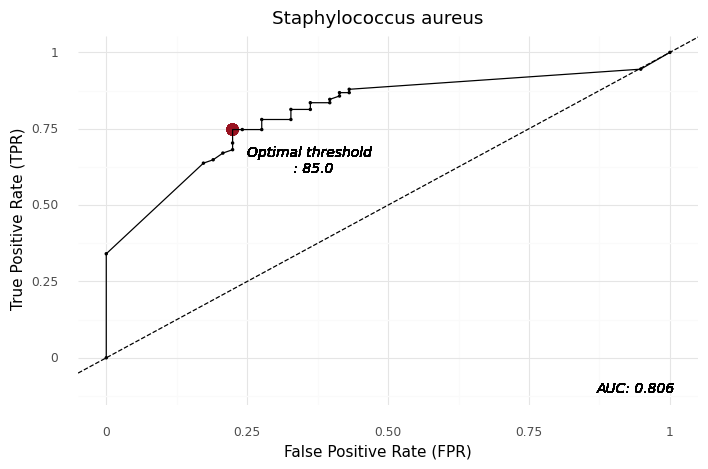

<ggplot: (166971778922)>

In [63]:
# Import module for data visualization
from plotnine import *
import plotnine


# Create the ROC curve
fpr, tpr, thresholds = roc_curve(SA['Resist_bool'], SA.PredValue)
fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(SA['Resist_bool'], SA.PredValue)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})


# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_abline(color='black',
                linetype="dashed")+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n : {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    geom_text(aes(x = 0.8,
                  y = 0),
              label = 'AUC: {}'.format(round(roc_auc, ndigits = 3)),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Staphylococcus aureus')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

Threshold  MRSA  MSSA
Actual               
MRSA         67    24
MSSA         13    45


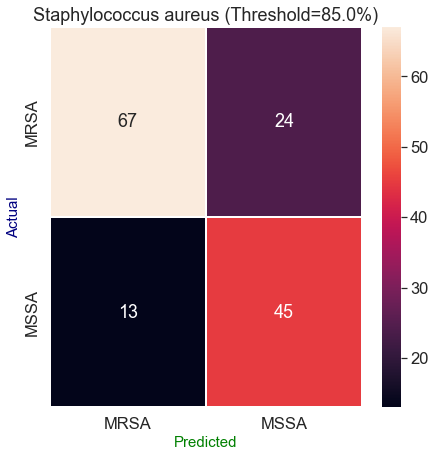

In [68]:
# confusion matrix
SA['Predicted'] = np.where(SA.PredValue>optimal_th, 'MRSA', 'MSSA')
# SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
confusion_matrix_SA = pd.crosstab(SA['Resist'], SA['Threshold'], rownames=['Actual'], colnames=['Threshold'])
print (confusion_matrix_SA)


plt.figure(figsize=(7,7))
sn.set(font_scale = 1.5)
sn.heatmap(confusion_matrix_SA, annot=True, fmt='d', linewidths=1.5)
plt.title(f'Staphylococcus aureus (Threshold={optimal_th:.1f}%)', fontsize = 18)
plt.xlabel('Predicted', fontsize = 15, color='green')
plt.ylabel('Actual', fontsize = 15, color='navy')
plt.show()

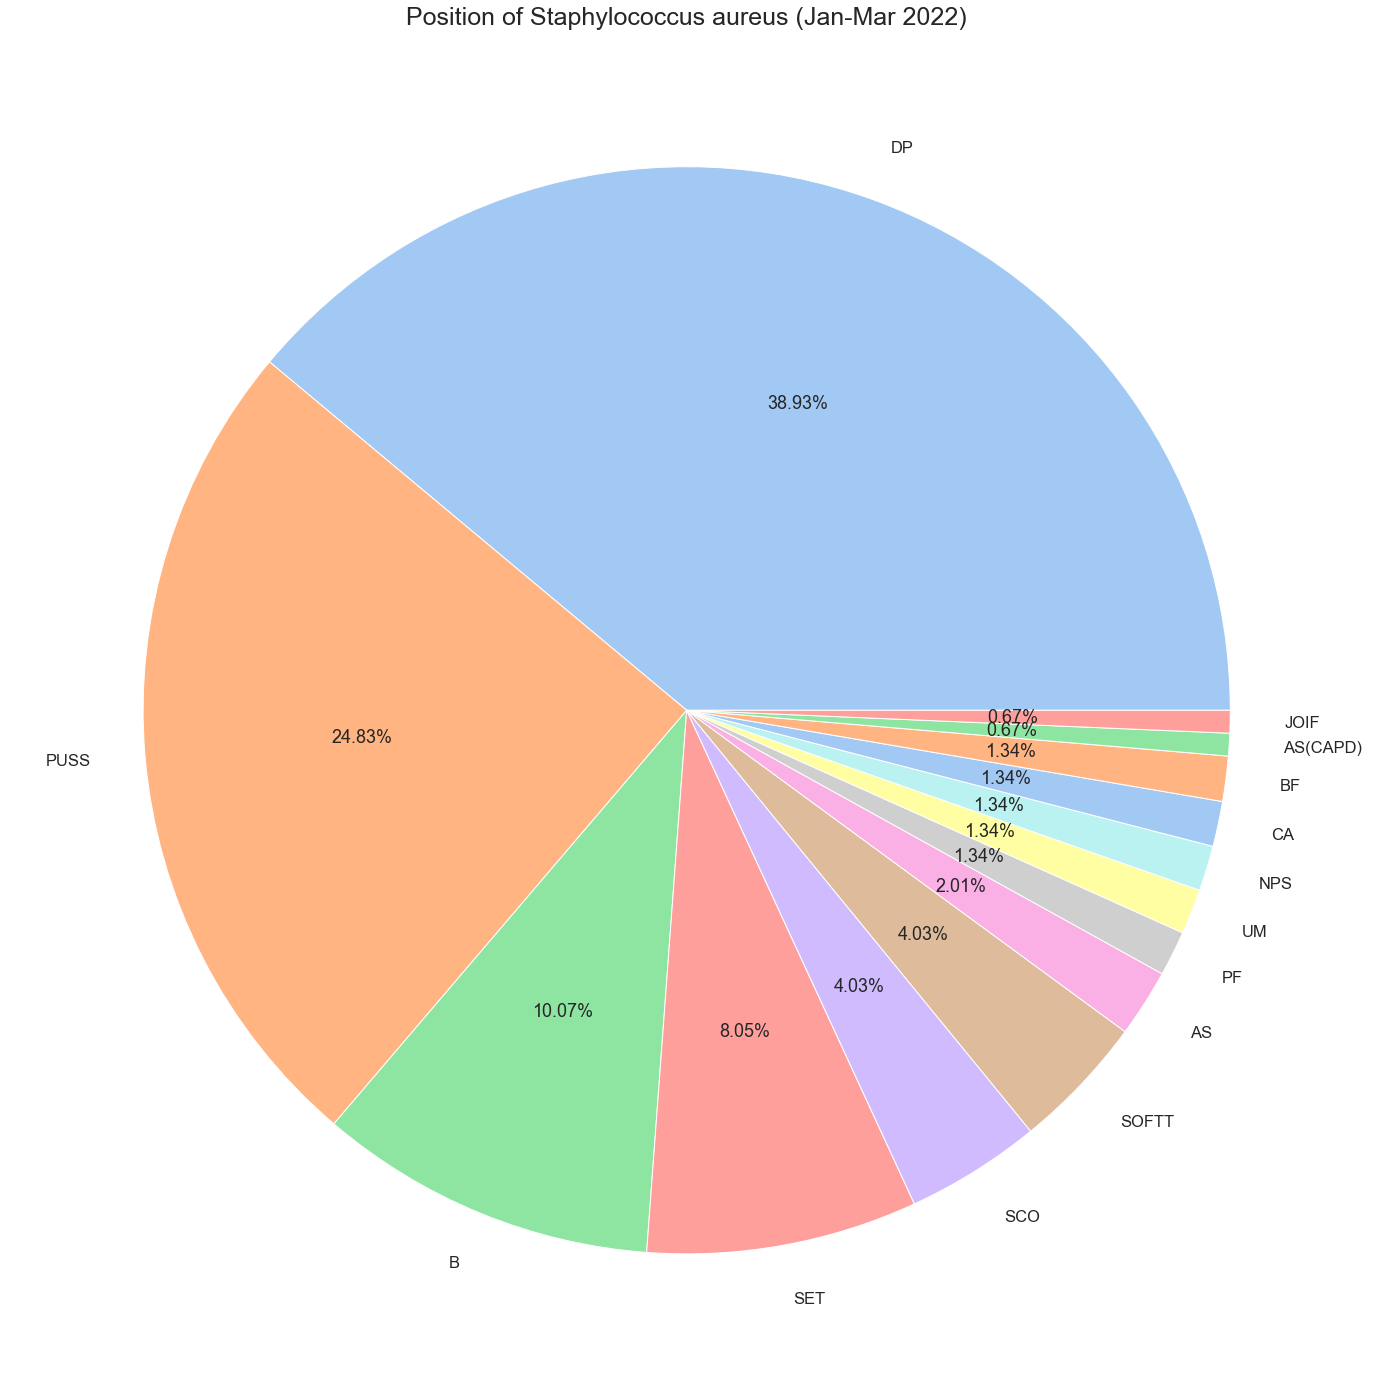

In [12]:
# change colour 

pieData = SA['部位'].value_counts()
label = pieData.index

colors = sn.color_palette('pastel')

#create pie chart
sn.set(font_scale = 1.5)
plt.figure(figsize=(25,25))
plt.pie(pieData, labels = label, autopct='%.2f%%', colors=colors)
plt.title('Position of Staphylococcus aureus (Jan-Mar 2022)', fontsize = 25)
plt.show()

In [66]:
for t in [80, 70, 60, 50]:
    SA['Threshold'] = np.where(SA.PredValue>t, 'MRSA', 'MSSA')
    # SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
    confusion_matrix_SA = pd.crosstab(SA['Resist'], SA['Threshold'], rownames=['Actual'], colnames=['Threshold'])
    print(f'Threshold : {t}')
    print (confusion_matrix_SA)
    

Threshold : 80
Threshold  MRSA  MSSA
Actual               
MRSA         68    23
MSSA         14    44
Threshold : 70
Threshold  MRSA  MSSA
Actual               
MRSA         71    20
MSSA         17    41
Threshold : 60
Threshold  MRSA  MSSA
Actual               
MRSA         73    18
MSSA         19    39
Threshold : 50
Threshold  MRSA  MSSA
Actual               
MRSA         75    16
MSSA         21    37


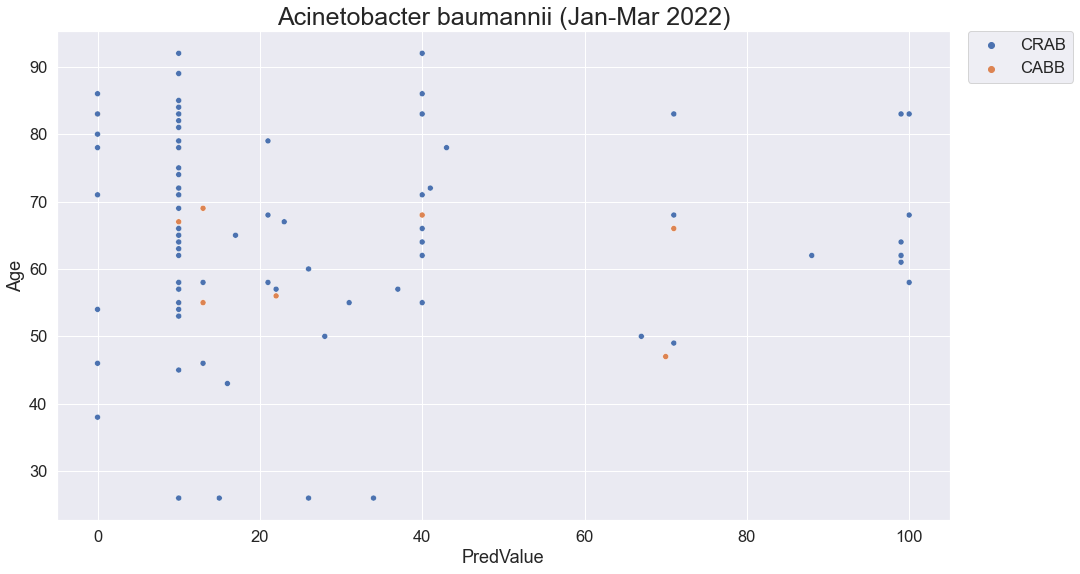

Strain: Acinetobacter baumannii (Jan-Mar 2022)
Amount: 136
Patient: 74

PredLevel  Resist
0~20%      CABB       9
           CRAB      82
21~40%     CABB       2
           CRAB      22
41~60%     CRAB       2
61~80%     CABB       2
           CRAB       5
81~100%    CRAB      12
Name: Resist, dtype: int64
Best Threshold: 15.0 with G-Mean: 0.4976
FPR: 0.3077, TPR: 0.3577


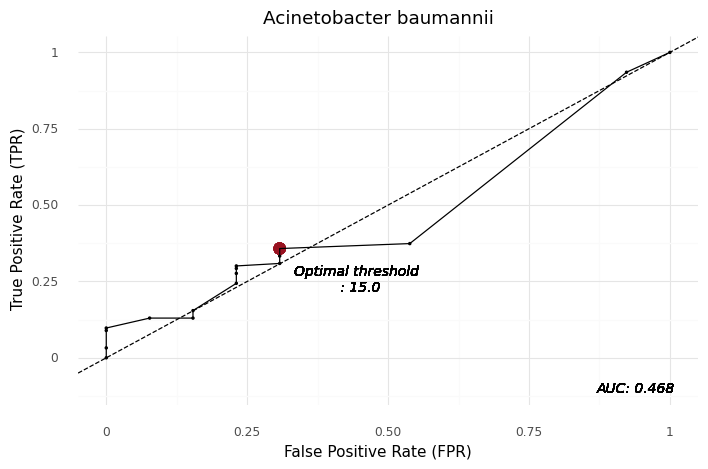

<ggplot: (166978164613)>

In [43]:
# Acinetobacter baumannii

AB = m[(m['菌株'] == 'Acinetobacter baumannii')|(m['菌株'] == 'Acinetobacter baumannii/calcoaceticus complex')]
AB = AB.drop_duplicates() 

AB = AB[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #101
AB['STRAIN'] = 'Staphylococcus aureus'

# add column 'predValue interval'
condition = [(AB['預測值'] <= 20), (AB['預測值'] > 20)&(AB['預測值'] <= 40), 
             (AB['預測值'] > 40)&(AB['預測值'] <= 60), (AB['預測值'] > 60)&(AB['預測值'] <= 80),
             (AB['預測值'] > 80)&(AB['預測值'] <= 100)]

value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
AB['PredLevel'] = np.select(condition, value)

# add column 'Resistance'
AB['Resist'] = np.where(AB['抗藥性菌株']==1, 'CRAB', 'CABB')
AB['Resist_bool'] = np.where(AB['Resist']=='CRAB', 1, 0)
AB.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Acinetobacter baumannii (Jan-Mar 2022)', fontsize = 25)


ax = sn.scatterplot(data=AB, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()


# distribution
print('Strain: Acinetobacter baumannii (Jan-Mar 2022)')
print('Amount:', AB['病歷號碼'].count())
print('Patient:', AB['病歷號碼'].drop_duplicates().count())
print()
print(AB.groupby('PredLevel')['Resist'].value_counts().sort_index())
AB.groupby('PredLevel')['PredValue'].describe()




# Import module for data visualization
from plotnine import *
import plotnine


# Create the ROC curve
fpr, tpr, thresholds = roc_curve(AB['Resist_bool'], AB.PredValue)
fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(AB['Resist_bool'], AB.PredValue)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})


# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_abline(color='black',
                linetype="dashed")+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n : {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    geom_text(aes(x = 0.8,
                  y = 0),
              label = 'AUC: {}'.format(round(roc_auc, ndigits = 3)),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Acinetobacter baumannii')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

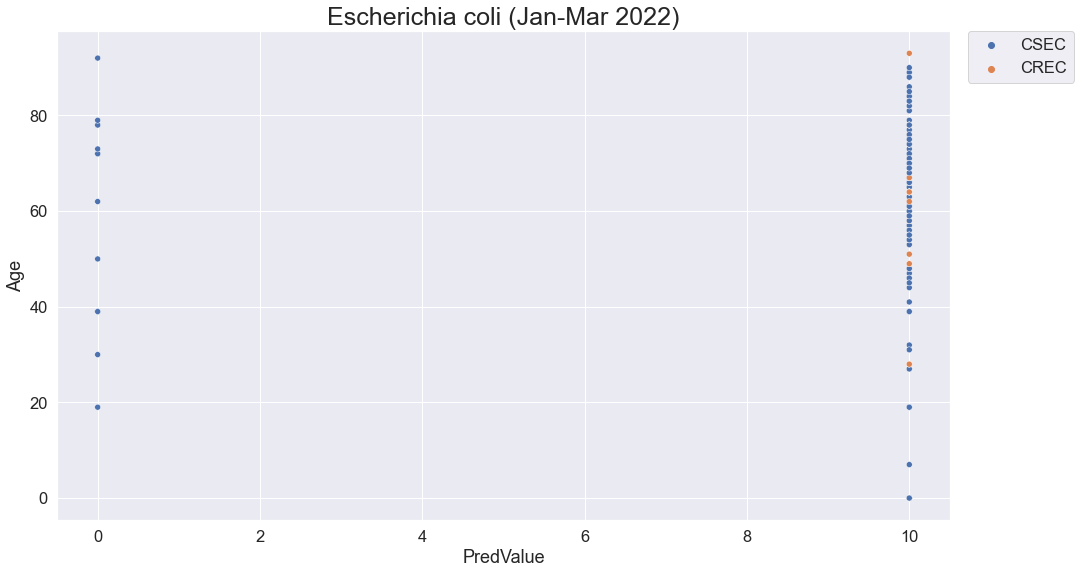

Strain: Escherichia coli (Jan-Mar 2022)
Amount: 181
Patient: 137

PredLevel  Resist
0~20%      CREC       24
           CSEC      157
Name: Resist, dtype: int64
Best Threshold: 10.0 with G-Mean: 0.3091
FPR: 0.9045, TPR: 1.0


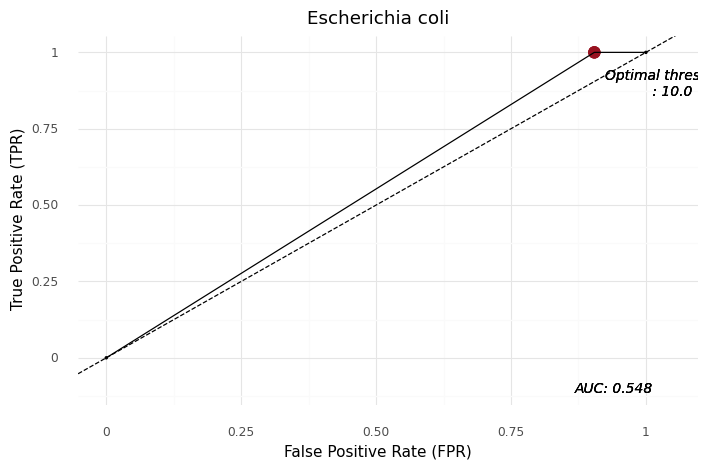

<ggplot: (166967301663)>

In [41]:
# Escherichia coli

EC = m[(m['菌株'] == 'Escherichia coli')]
EC = EC.drop_duplicates() 

EC = EC[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #101
EC['STRAIN'] = 'Escherichia coli'

# add column 'predValue interval'
condition = [(EC['預測值'] <= 20), (EC['預測值'] > 20)&(EC['預測值'] <= 40), 
             (EC['預測值'] > 40)&(EC['預測值'] <= 60), (EC['預測值'] > 60)&(EC['預測值'] <= 80),
             (EC['預測值'] > 80)&(EC['預測值'] <= 100)]

value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
EC['PredLevel'] = np.select(condition, value)

# add column 'Resistance'
EC['Resist'] = np.where(EC['抗藥性菌株']==1, 'CREC', 'CSEC')
EC['Resist_bool'] = np.where(EC['Resist']=='CREC', 1, 0)
EC.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Escherichia coli (Jan-Mar 2022)', fontsize = 25)


ax = sn.scatterplot(data=EC, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()


# distribution
print('Strain: Escherichia coli (Jan-Mar 2022)')
print('Amount:', EC['病歷號碼'].count())
print('Patient:', EC['病歷號碼'].drop_duplicates().count())
print()
print(EC.groupby('PredLevel')['Resist'].value_counts().sort_index())
EC.groupby('PredLevel')['PredValue'].describe()

# Import module for data visualization
from plotnine import *
import plotnine


# Create the ROC curve
fpr, tpr, thresholds = roc_curve(EC['Resist_bool'], EC.PredValue)
fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(EC['Resist_bool'], EC.PredValue)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})


# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_abline(color='black',
                linetype="dashed")+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n : {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    geom_text(aes(x = 0.8,
                  y = 0),
              label = 'AUC: {}'.format(round(roc_auc, ndigits = 3)),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Escherichia coli')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)


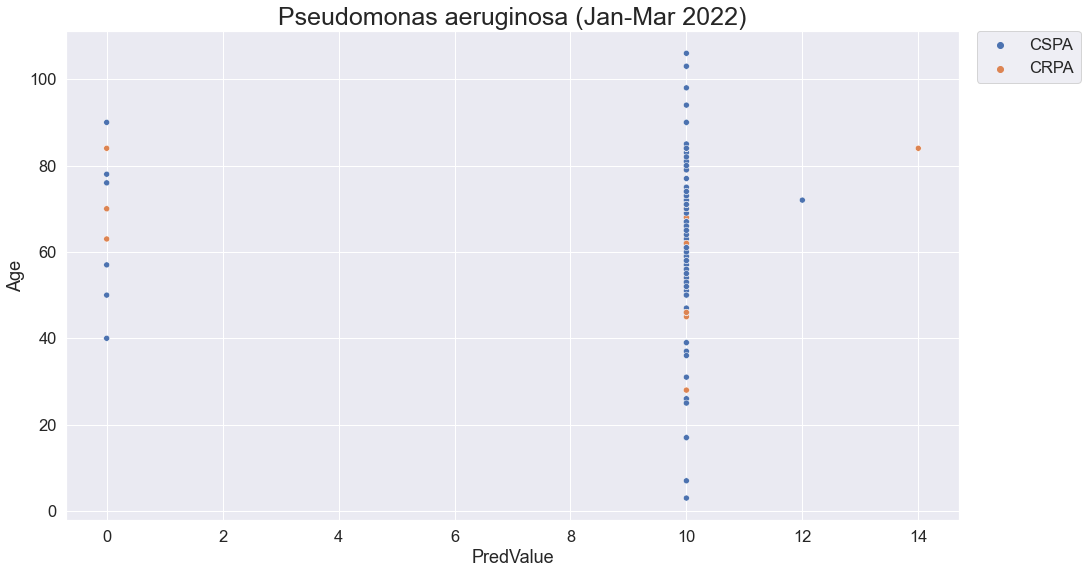

Strain: Pseudomonas aeruginosa (Jan-Mar 2022)
Amount: 150
Patient: 106

PredLevel  Resist
0~20%      CRPA       20
           CSPA      130
Name: Resist, dtype: int64
Best Threshold: 10.0 with G-Mean: 0.2287
FPR: 0.9385, TPR: 0.85


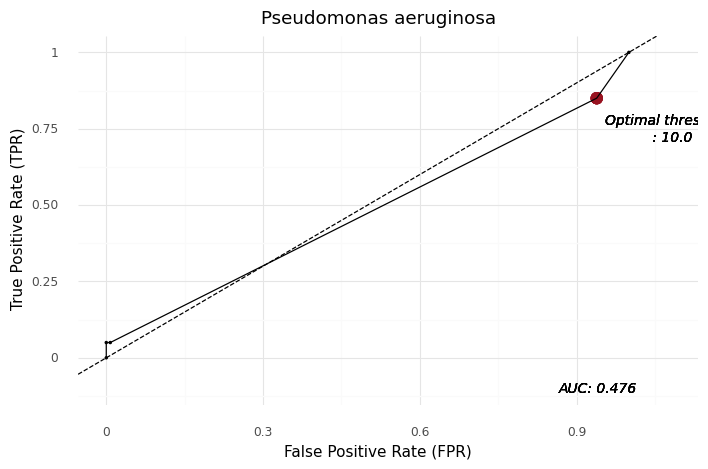

<ggplot: (166967454961)>

In [44]:
# Pseudomonas aeruginosa

PA = m[(m['菌株'] == 'Pseudomonas aeruginosa')]
PA = PA.drop_duplicates() 

PA = PA[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #101
PA['STRAIN'] = 'Pseudomonas aeruginosa'

# add column 'predValue interval'
condition = [(PA['預測值'] <= 20), (PA['預測值'] > 20)&(PA['預測值'] <= 40), 
             (PA['預測值'] > 40)&(PA['預測值'] <= 60), (PA['預測值'] > 60)&(PA['預測值'] <= 80),
             (PA['預測值'] > 80)&(PA['預測值'] <= 100)]

value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
PA['PredLevel'] = np.select(condition, value)

# add column 'Resistance'
PA['Resist'] = np.where(PA['抗藥性菌株']==1, 'CRPA', 'CSPA')
PA['Resist_bool'] = np.where(PA['Resist']=='CRPA', 1, 0)
PA.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Pseudomonas aeruginosa (Jan-Mar 2022)', fontsize = 25)


ax = sn.scatterplot(data=PA, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()


# distribution
print('Strain: Pseudomonas aeruginosa (Jan-Mar 2022)')
print('Amount:', PA['病歷號碼'].count())
print('Patient:', PA['病歷號碼'].drop_duplicates().count())
print()
print(PA.groupby('PredLevel')['Resist'].value_counts().sort_index())
PA.groupby('PredLevel')['PredValue'].describe()

# Import module for data visualization
from plotnine import *
import plotnine


# Create the ROC curve
fpr, tpr, thresholds = roc_curve(PA['Resist_bool'], PA.PredValue)
fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(PA['Resist_bool'], PA.PredValue)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})


# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_abline(color='black',
                linetype="dashed")+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n : {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    geom_text(aes(x = 0.8,
                  y = 0),
              label = 'AUC: {}'.format(round(roc_auc, ndigits = 3)),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Pseudomonas aeruginosa')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)


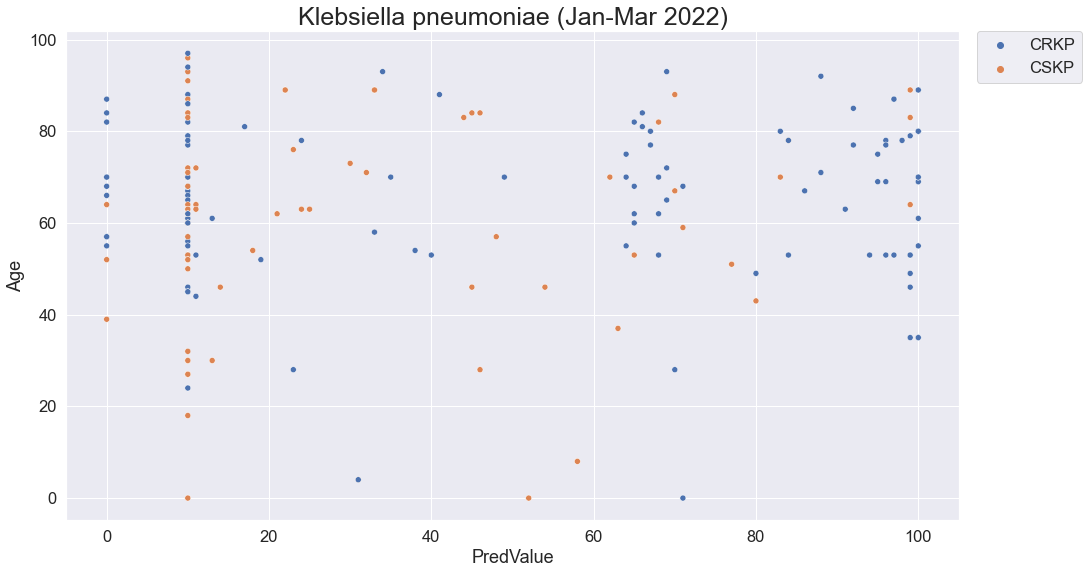

Strain: Klebsiella pneumoniae (Jan-Mar 2022)
Amount: 213
Patient: 145

PredLevel  Resist
0~20%      CRKP      60
           CSKP      47
21~40%     CRKP       8
           CSKP      11
41~60%     CRKP       2
           CSKP       9
61~80%     CRKP      21
           CSKP       9
81~100%    CRKP      41
           CSKP       5
Name: Resist, dtype: int64
Best Threshold: 64.0 with G-Mean: 0.6325
FPR: 0.1481, TPR: 0.4697


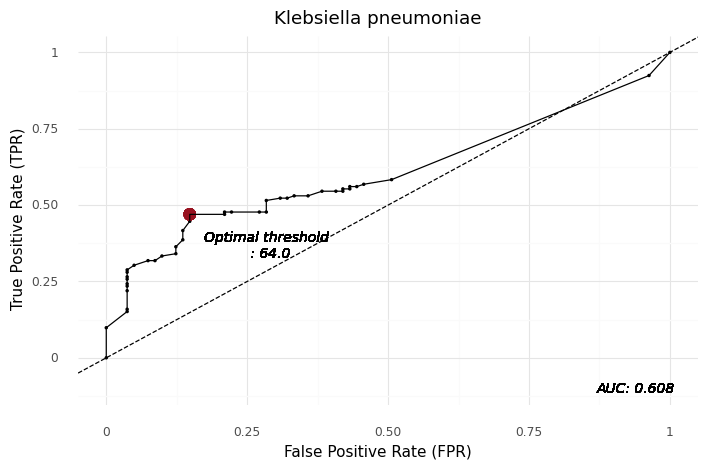

<ggplot: (166967849795)>

In [45]:
# Klebsiella pneumoniae

KP = m[(m['菌株'] == 'Klebsiella pneumoniae')]
KP = KP.drop_duplicates() 

KP = KP[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #101
KP['STRAIN'] = 'Klebsiella pneumoniae'

# add column 'predValue interval'
condition = [(KP['預測值'] <= 20), (KP['預測值'] > 20)&(KP['預測值'] <= 40), 
             (KP['預測值'] > 40)&(KP['預測值'] <= 60), (KP['預測值'] > 60)&(KP['預測值'] <= 80),
             (KP['預測值'] > 80)&(KP['預測值'] <= 100)]

value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
KP['PredLevel'] = np.select(condition, value)

# add column 'Resistance'
KP['Resist'] = np.where(KP['抗藥性菌株']==1, 'CRKP', 'CSKP')
KP['Resist_bool'] = np.where(KP['Resist']=='CRKP', 1, 0)
KP.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Klebsiella pneumoniae (Jan-Mar 2022)', fontsize = 25)


ax = sn.scatterplot(data=KP, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()


# distribution
print('Strain: Klebsiella pneumoniae (Jan-Mar 2022)')
print('Amount:', KP['病歷號碼'].count())
print('Patient:', KP['病歷號碼'].drop_duplicates().count())
print()
print(KP.groupby('PredLevel')['Resist'].value_counts().sort_index())
KP.groupby('PredLevel')['PredValue'].describe()

# Import module for data visualization
from plotnine import *
import plotnine


# Create the ROC curve
fpr, tpr, thresholds = roc_curve(KP['Resist_bool'], KP.PredValue)
fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(KP['Resist_bool'], KP.PredValue)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})


# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_abline(color='black',
                linetype="dashed")+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n : {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    geom_text(aes(x = 0.8,
                  y = 0),
              label = 'AUC: {}'.format(round(roc_auc, ndigits = 3)),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Klebsiella pneumoniae')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)


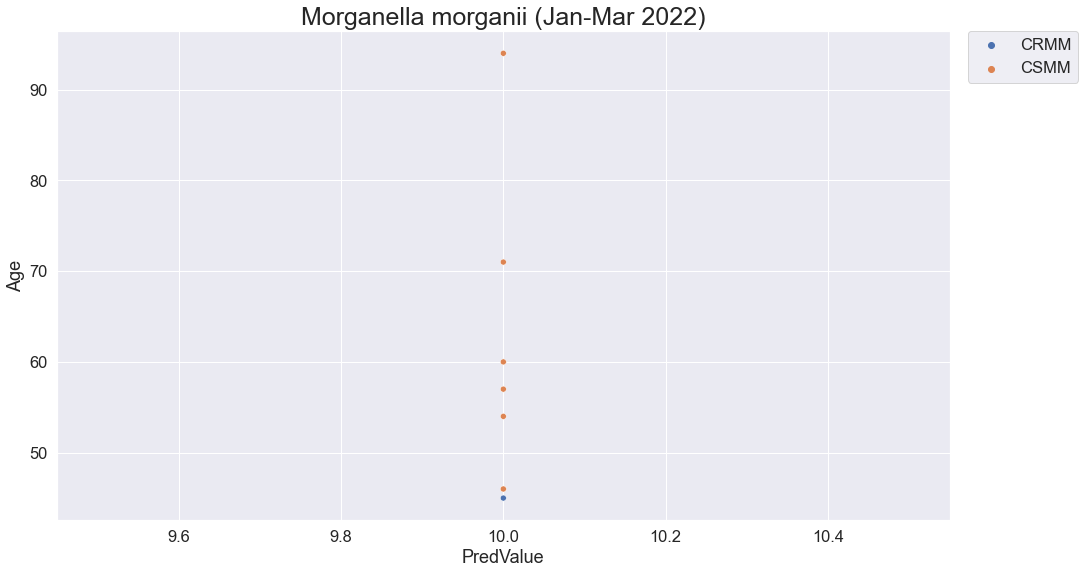

Strain: Morganella morganii (Jan-Mar 2022)
Amount: 8
Patient: 7

PredLevel  Resist
0~20%      CRMM      1
           CSMM      7
Name: Resist, dtype: int64
Best Threshold: 11.0 with G-Mean: 0.0
FPR: 0.0, TPR: 0.0


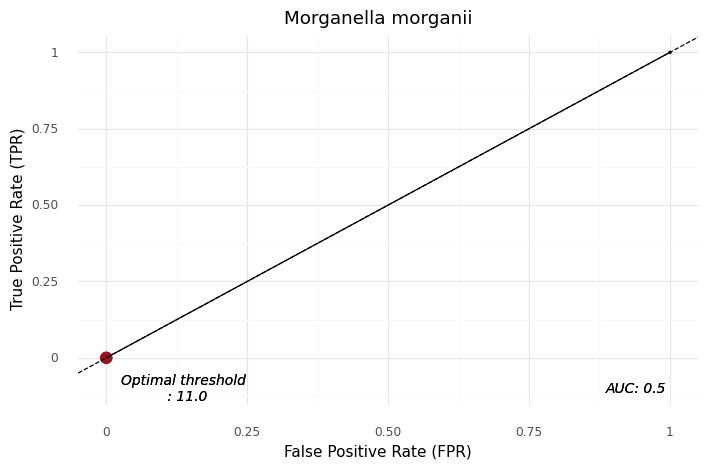

<ggplot: (166972180396)>

In [47]:
# Morganella morganii

MM = m[(m['菌株'] == 'Morganella morganii')]
MM = MM.drop_duplicates() 

MM = MM[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #101
MM['STRAIN'] = 'Morganella morganii'

# add column 'predValue interval'
condition = [(MM['預測值'] <= 20), (MM['預測值'] > 20)&(MM['預測值'] <= 40), 
             (MM['預測值'] > 40)&(MM['預測值'] <= 60), (MM['預測值'] > 60)&(MM['預測值'] <= 80),
             (MM['預測值'] > 80)&(MM['預測值'] <= 100)]

value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
MM['PredLevel'] = np.select(condition, value)

# add column 'Resistance'
MM['Resist'] = np.where(MM['抗藥性菌株']==1, 'CRMM', 'CSMM')
MM['Resist_bool'] = np.where(MM['Resist']=='CRMM', 1, 0)
MM.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Morganella morganii (Jan-Mar 2022)', fontsize = 25)


ax = sn.scatterplot(data=MM, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()


# distribution
print('Strain: Morganella morganii (Jan-Mar 2022)')
print('Amount:', MM['病歷號碼'].count())
print('Patient:', MM['病歷號碼'].drop_duplicates().count())
print()
print(MM.groupby('PredLevel')['Resist'].value_counts().sort_index())
MM.groupby('PredLevel')['PredValue'].describe()

# Import module for data visualization
from plotnine import *
import plotnine


# Create the ROC curve
fpr, tpr, thresholds = roc_curve(MM['Resist_bool'], MM.PredValue)
fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(MM['Resist_bool'], MM.PredValue)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})


# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_abline(color='black',
                linetype="dashed")+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n : {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    geom_text(aes(x = 0.8,
                  y = 0),
              label = 'AUC: {}'.format(round(roc_auc, ndigits = 3)),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Morganella morganii')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)


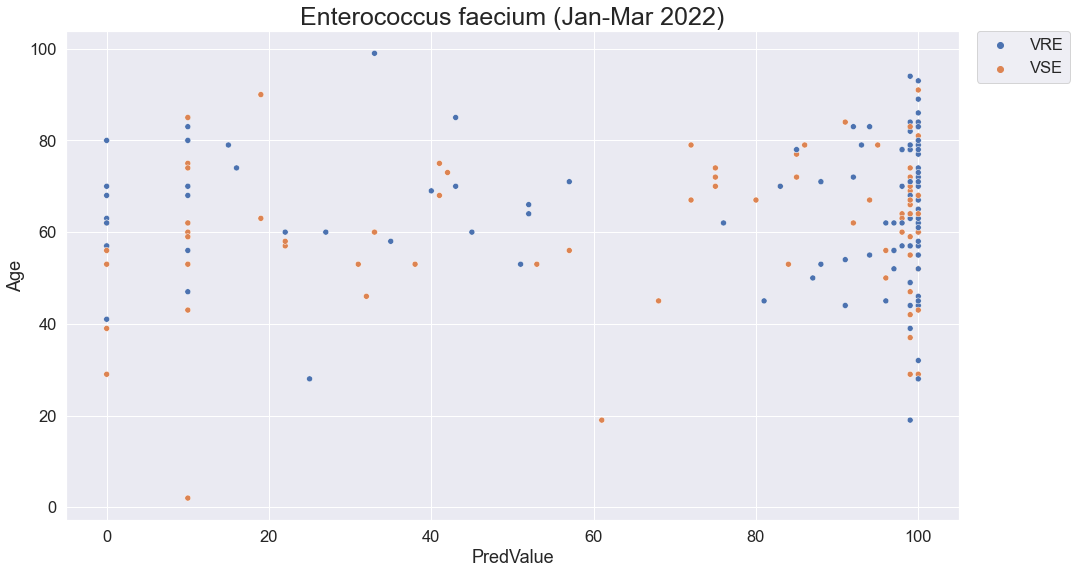

Strain: Enterococcus faecium (Jan-Mar 2022)
Amount: 233
Patient: 157

PredLevel  Resist
0~20%      VRE        22
           VSE        18
21~40%     VRE         6
           VSE         6
41~60%     VRE         7
           VSE         5
61~80%     VRE         1
           VSE         8
81~100%    VRE       113
           VSE        47
Name: Resist, dtype: int64
Best Threshold: 87.0 with G-Mean: 0.6048
FPR: 0.5, TPR: 0.7315


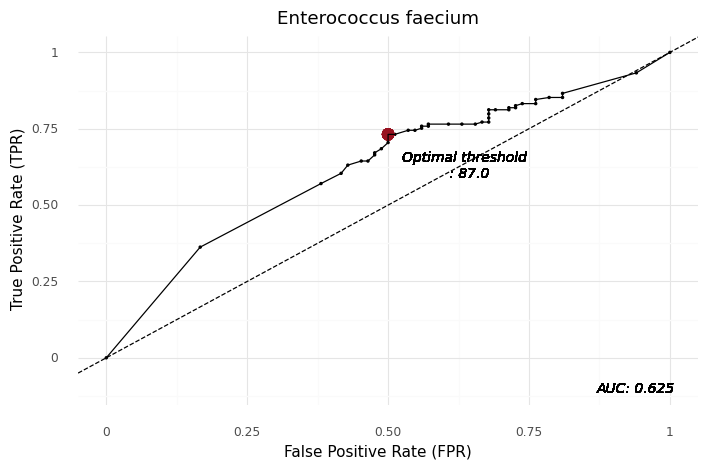

<ggplot: (166974583474)>

In [48]:
# Enterococcus faecium

EF = m[(m['菌株'].isin(['Enterococcus faecium(VRE)', 'Enterococcus faecium', 'Enterococcus faecalis']))]
EF = EF.drop_duplicates() 

EF = EF[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', '年齡', '抗藥性菌株', 'examTime',
       'reportTime', 'openTime', '菌株', '預測值', 'sendTime']].drop_duplicates() #101
EF['STRAIN'] = 'Enterococcus faecium'

# add column 'predValue interval'
condition = [(EF['預測值'] <= 20), (EF['預測值'] > 20)&(EF['預測值'] <= 40), 
             (EF['預測值'] > 40)&(EF['預測值'] <= 60), (EF['預測值'] > 60)&(EF['預測值'] <= 80),
             (EF['預測值'] > 80)&(EF['預測值'] <= 100)]

value = ['0~20%', '21~40%', '41~60%', '61~80%', '81~100%']
EF['PredLevel'] = np.select(condition, value)

# add column 'Resistance'
EF['Resist'] = np.where(EF['抗藥性菌株']==1, 'VRE', 'VSE')
EF['Resist_bool'] = np.where(EF['Resist']=='VRE', 1, 0)
EF.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# scatter plot

plt.figure(figsize=(16, 9))
sn.set(font_scale = 1.5)
plt.title('Enterococcus faecium (Jan-Mar 2022)', fontsize = 25)


ax = sn.scatterplot(data=EF, x="PredValue", y="Age", hue="Resist")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='upper right')
# sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

plt.show()


# distribution
print('Strain: Enterococcus faecium (Jan-Mar 2022)')
print('Amount:', EF['病歷號碼'].count())
print('Patient:', EF['病歷號碼'].drop_duplicates().count())
print()
print(EF.groupby('PredLevel')['Resist'].value_counts().sort_index())
EF.groupby('PredLevel')['PredValue'].describe()

# Import module for data visualization
from plotnine import *
import plotnine


# Create the ROC curve
fpr, tpr, thresholds = roc_curve(EF['Resist_bool'], EF.PredValue)
fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(EF['Resist_bool'], EF.PredValue)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})


# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_abline(color='black',
                linetype="dashed")+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n : {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    geom_text(aes(x = 0.8,
                  y = 0),
              label = 'AUC: {}'.format(round(roc_auc, ndigits = 3)),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Enterococcus faecium')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)


In [94]:
m['month'] = pd.to_datetime(m['openTime']).dt.month
m['抗藥性菌株'] = np.where(m['抗藥性菌株']==1, 1, 0)
jan = m[m['month']==1][['病歷號碼', 'examTime', '部位', '抗藥性菌株', '菌株', '天數']].drop_duplicates()
feb = m[m['month']==2][['病歷號碼', 'examTime', '部位', '抗藥性菌株', '菌株', '天數']].drop_duplicates()
mar = m[m['month']==3][['病歷號碼', 'examTime', '部位', '抗藥性菌株', '菌株', '天數']].drop_duplicates()  

C:\Users\User\AppData\Local\Temp\ipykernel_10568\3821060781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\AppData\Local\Temp\ipykernel_10568\3821060781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [95]:
jan['天數'].sum()/jan['天數'].count()

49.64451827242525

In [96]:
feb['天數'].sum()/feb['天數'].count()

44.904347826086955

In [97]:
mar['天數'].sum()/mar['天數'].count()

29.452380952380953

In [98]:
mar.drop_duplicates()

,病歷號碼,examTime,部位,抗藥性菌株,菌株,天數
58308,0028815585,2022-02-24 08:50,DP,1,Enterococcus faecalis,32.0
58318,0028815585,2022-02-24 08:50,DP,1,Enterobacter cloacae,32.0
58338,0028815585,2022-02-24 08:50,DP,0,Enterococcus faecalis,32.0
58883,0033290373,2022-02-25 10:02,B,0,Escherichia coli,20.0
58886,0033290373,2022-02-25 10:02,B,0,Pseudomonas aeruginosa,20.0
...,...,...,...,...,...,...
99868,0036261148,2022-03-28 16:43,DP,0,Enterococcus faecalis,22.0
99880,0024270674,2022-03-28 15:41,DP,1,Enterococcus faecium,23.0
99887,0024270674,2022-03-28 15:41,DP,1,Acinetobacter baumannii,23.0
99913,0000880787,2022-03-28 16:43,DP,1,Klebsiella pneumoniae,34.0


546